# **ESERCIZIO 7**

### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.


## Soluzione

L'approssimazione del **raggio di cut-off** può portare a risultati errati, poiché il potenziale di **Lennard-Jones** descrive un'interazione a **lungo raggio**.  
Per migliorare questa approssimazione si possono considerare le cosiddette **correzioni di coda** (*tail corrections*), calcolate utilizzando la **funzione di distribuzione radiale**.

In **unità ridotte**, queste correzioni assumono la seguente forma:

### Correzione di coda del potenziale:

$$
U_{\text{tail}} = \dfrac{8\pi \rho}{3} \left[ \dfrac{1}{3r_c^9} - \dfrac{1}{r_c^3} \right]
$$

### Correzione di coda della pressione:

$$
P_{\text{tail}} = \dfrac{16\pi \rho^2}{3} \left[ \dfrac{2}{3r_c^9} - \dfrac{1}{r_c^3} \right]
$$

Una volta implementate nel codice del simulatore, le **correzioni di coda** assumono ad esempio i seguenti valori per la **fase gassosa**:

- **Correzione di coda del potenziale**:  
  `_vtail = (8*M_PI*_rho/(9*pow(_r_cut,9))) - (8*M_PI*_rho/(3*pow(_r_cut,3)));`
  
- **Correzione di coda della pressione**:  
  `_ptail = 32*M_PI*_rho*(1/(9*pow(_r_cut,9))-1/(6*pow(_r_cut,3)));`



### Exercise 07.2

Use the NSL simulator code to print out **instantaneous** values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations of $M=5\times 10^5$ MC steps or MD time steps (where, for MC, the Metropolis acceptance ratio should be fixed approximately to 50% by changing the value of $dt$ that, in the MC case, represent the amplitude of the step in each direction) in the following thermodynamic conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for MD $dt^\star=0.001$)


Equilibration is needed both with MC and with MD. With MD, you will observe that starting from a perfect crystalline configuration the temperature, $T$, will not conserve its value. Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$.
Perform your MC and MD simulations by re-starting after such equilibration time.

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
import os


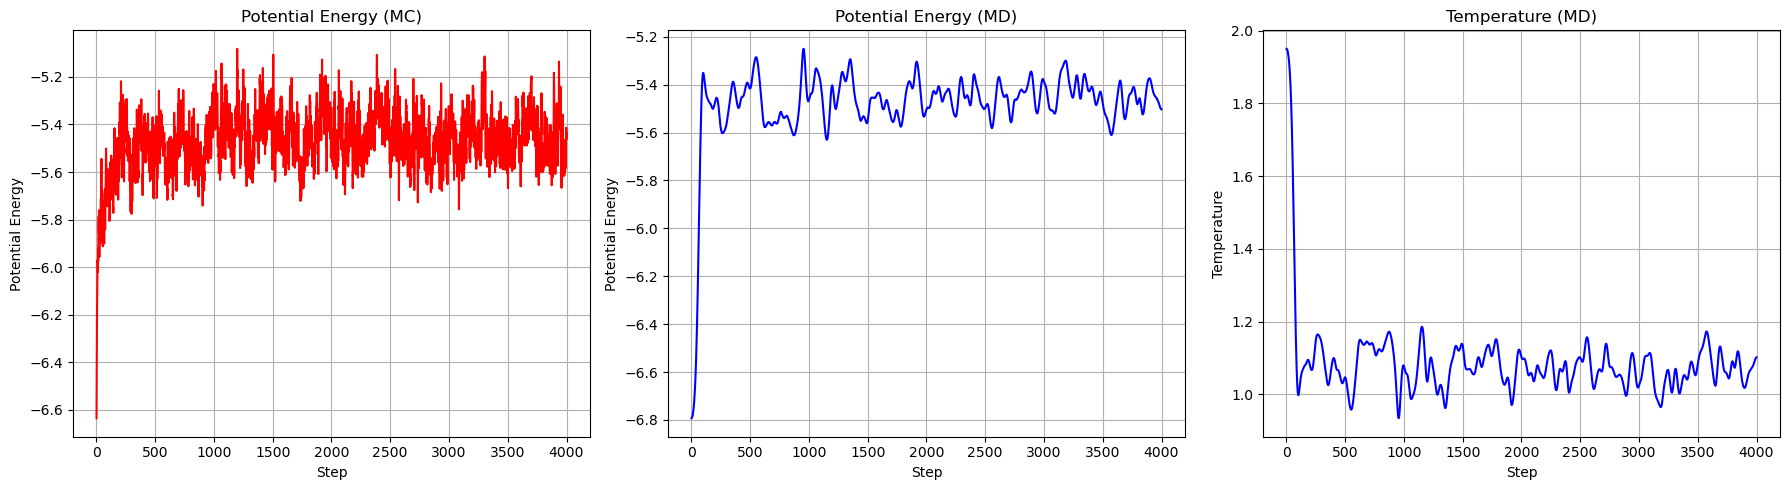

In [10]:
md_temp = pd.read_csv("OUTPUT/EQUILIBRATION/MD/temperature_1_95.dat", delim_whitespace=True)
md_pot = pd.read_csv("OUTPUT/EQUILIBRATION/MD/potential_energy_1_95.dat", delim_whitespace=True)
mc_pot = pd.read_csv("OUTPUT/EQUILIBRATION/MC/potential_energyLJ_MC.dat", delim_whitespace=True)

fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

# 1. Energia potenziale (Molecular Dynamics)
axs[0].plot(mc_pot['BLOCK:'], mc_pot['ACTUAL_PE:'], color='red', label='MC Potential Energy')
axs[0].set_title('Potential Energy (MC)')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Potential Energy')
axs[0].grid()

# 2. Energia potenziale (Monte Carlo)
axs[1].plot(md_pot['BLOCK:'], md_pot['ACTUAL_PE:'], color='blue', label='MD Potential Energy')
axs[1].set_title('Potential Energy (MD)')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Potential Energy')
axs[1].grid()

# 3. Temperatura (MD)
axs[2].plot(md_temp['BLOCK:'], md_temp['ACTUAL_T:'], color='blue', label='MD Temperature')
axs[2].set_title('Temperature (MD)')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Temperature')
axs[2].grid()

# Layout finale
plt.tight_layout()
plt.show()


Notiamo che già dopo $\sim 10^3$ steps il sistema si è già assestato dui suoi valori di equilibrio, sia per quanto riguarda la simulazione di Molecular Dynamics, sia per la simulazione Montecarlo.
Pertanto ho implementato un metodo di equilibrazione nella classe System ( `Equilibrate()` ) che fa scorrere il sistema "a vuoto" per 2000 steps: il sistema si evolve con il metodo `Step()`, ma senza che vengano mai chiamate le funzioni `measure()` ed `averages()`. In questo modo il sistema raggiunge l'equilibrio senza misurare le quantità. Solo in un secondo momento Inizia la vera e prorpia misura delle quantità di interesse.


Nella simulazione NVE di Dinamica Molecolare, il grafico centrale mostra chiaramente come la temperatura iniziale, impostata tramite il file input.dat, sia significativamente diversa da quella che il sistema raggiunge all'equilibrio.

Questo accade perché, in un sistema NVE, la temperatura non è controllata direttamente, ma deriva dall'energia cinetica delle particelle. All'inizio della simulazione, le particelle sono disposte in modo regolare, ad esempio su un reticolo cristallino, ma le velocità sono assegnate casualmente, generando un valore iniziale dell’energia cinetica che può non essere compatibile con la configurazione iniziale dell’energia potenziale.

Nel corso della dinamica, il sistema evolve cercando un equilibrio tra energia cinetica e potenziale, in modo da conservare l'energia totale (caratteristica dell'ensemble NVE). Questo porta a uno scambio energetico tra K e 
U, e quindi a un aggiustamento naturale della temperatura, che tende a stabilizzarsi intorno a un valore di equilibrio, pur con normali fluttuazioni statistiche.

Poiché l'energia cinetica iniziale è superiore a quella tipica dell’equilibrio, il sistema perde energia cinetica (trasferendola in potenziale) e quindi la temperatura diminuisce fino ad assestarsi.

La relazione tra temperatura e energia cinetica media in un sistema classico di 
N particelle in 3 dimensioni è:

$$\langle K \rangle = \frac{3}{2} N k_B T$$

Siccome la richiesta prevede di paragonare le due simulazioni 

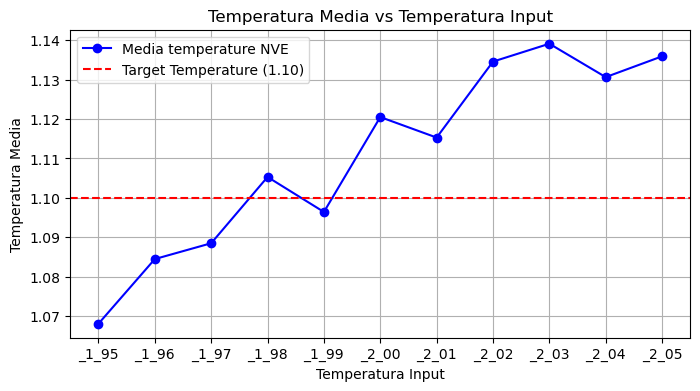

Valore trovato che più si avvicina a <T_fin = 1.1>  =': _1_99
differenza valore_trovato-valore_ottimale = 0.00358157266666681


In [11]:
path = 'OUTPUT/EQUILIBRATION/MD/'
temp_v = ["_1_95", '_1_96', '_1_97', '_1_98', '_1_99', '_2_00', '_2_01', '_2_02', '_2_03', '_2_04', '_2_05']

t_list = []
average_t_list = []

for t in temp_v:
    file_name = f'temperature{t}.dat'
    file_path = os.path.join(path, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, delim_whitespace=True)
        average_t = data['ACTUAL_T:'][-3000:].mean()
        t_list.append(t)
        average_t_list.append(average_t)

diffs = np.abs(np.array(average_t_list) - 1.1)
index = np.argmin(diffs)
closest_t = t_list[index]



plt.figure(figsize=(8, 4))
plt.plot(t_list, average_t_list, marker='o', color='blue', label='Media temperature NVE')
plt.axhline(y = 1.1, color='red', linestyle='--', label='Target Temperature (1.10)')
plt.title('Temperatura Media vs Temperatura Input')
plt.xlabel('Temperatura Input')
plt.ylabel('Temperatura Media')
plt.grid()
plt.legend()
plt.show()

print(f"Valore trovato che più si avvicina a <T_fin = 1.1>  =': {closest_t}")
print(f"differenza valore_trovato-valore_ottimale = {diffs[index]}")

Anche solo visivamente notiamo come il miglior valore di Input per la Temperatura del modello NVE sia TEMP = 1.99 .  Con questo valore, una volta raggiunto l'equilibrio, la differenza di temperatura tra modello NVE ed NVT vale $\Delta T = 0.0036$ 

### AUTOCORRELAZIONE

In [18]:
# AUTOCORRELAZIONE

def autocorrelazione( data  , maxlag):
    chi_vec=[]
    denom = np.var(data)

    
    for t in range(maxlag):
        M= len(data)-t
        part1 = data[:M]
        part2 = data[t:]

        

        somm1 = np.dot(part1, part2 )/M
        ave1 = np.mean(part1)
        ave2= np.mean(part2)
        
        chi =  (somm1 - ave1*ave2)/denom
        chi_vec.append(chi)
    return chi_vec

    

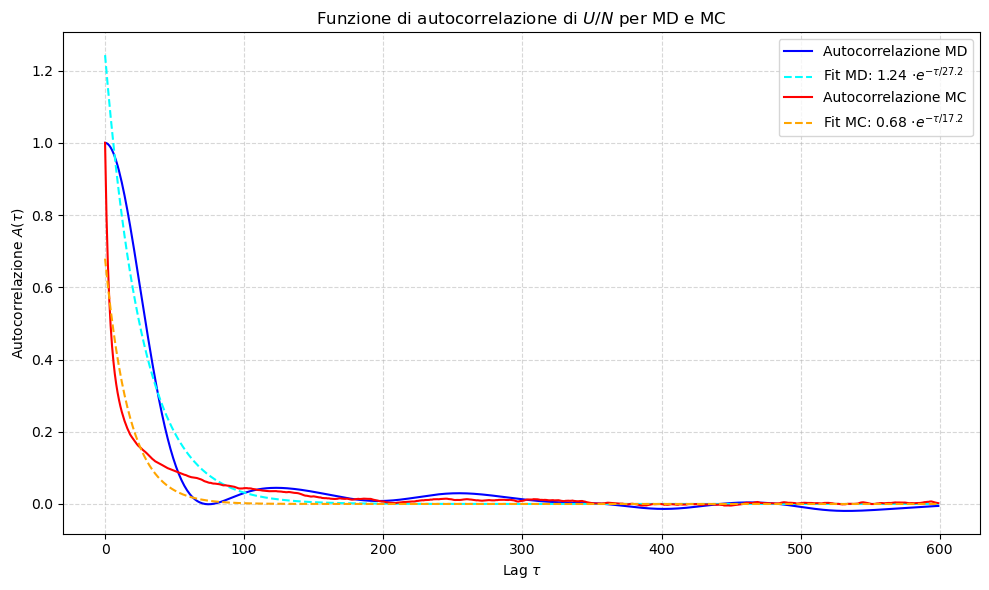

Tempo di autocorrelazione stimato MD: tau = 27.17
Tempo di autocorrelazione stimato MC: tau = 17.24


In [19]:
import statsmodels.api as sm
from scipy.optimize import curve_fit

def expo(t, a, b):
    return a * np.exp(-t / b)

# Carica i dati
pot_autocorr_md = pd.read_csv("OUTPUT/AUTOCORRELATION/potential_energyLJ_MD.dat", delim_whitespace=True)
pot_autocorr_mc = pd.read_csv("OUTPUT/AUTOCORRELATION/potential_energyLJ_MC.dat", delim_whitespace=True)

# Normalizza dati MD
data_md = pot_autocorr_md['ACTUAL_PE:'].values
data_md = (data_md - np.mean(data_md)) / np.std(data_md)

# Normalizza dati MC
data_mc = pot_autocorr_mc['ACTUAL_PE:'].values
data_mc = (data_mc - np.mean(data_mc)) / np.std(data_mc)

maxlag = 600

# Calcola autocorrelazioni
acf_md= autocorrelazione(data_md,maxlag)
acf_mc= autocorrelazione(data_mc,maxlag)


#acf_md = sm.tsa.acf(data_md, nlags=maxlag, fft=True)
#acf_mc = sm.tsa.acf(data_mc, nlags=maxlag, fft=True)

lags = np.arange(len(acf_md))

# Fit esponenziale MD
popt_md, _ = curve_fit(expo, lags, acf_md, bounds=([0, 0], [2, np.inf]))

# Fit esponenziale MC
popt_mc, _ = curve_fit(expo, lags, acf_mc, bounds=([0, 0], [2, np.inf]))

# Plot
plt.figure(figsize=(10,6))
plt.plot(lags, acf_md[:1000], label='Autocorrelazione MD', color='blue')
plt.plot(lags, expo(lags, *popt_md), '--', color='cyan', 
         label=fr'Fit MD: {popt_md[0]:.2f} $\cdot e^{{-\tau/{popt_md[1]:.1f}}}$')

plt.plot(lags, acf_mc[:1000], label='Autocorrelazione MC', color='red')
plt.plot(lags, expo(lags, *popt_mc), '--', color='orange', 
         label=fr'Fit MC: {popt_mc[0]:.2f} $\cdot e^{{-\tau/{popt_mc[1]:.1f}}}$')

plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'Autocorrelazione $A(\tau)$')
plt.title(r'Funzione di autocorrelazione di $U/N$ per MD e MC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Tempo di autocorrelazione stimato MD: tau = {popt_md[1]:.2f}")
print(f"Tempo di autocorrelazione stimato MC: tau = {popt_mc[1]:.2f}")

Il plot mostra come l'autocorrelazione tra i valori diminuisce in funzione del lag temporale $\tau$, già dopo qualche centinaio di step i valori delle grndezze misurate dalla simulazione sono quasi del tutto scorrelati da quelli iniziali. Pertanto ho deciso di utilizzare blocchi composti da $10^3$ step in modo da avere la certezza che i valori ottenuti in blocchi diversi fossero praticamente del tutto scorrelati.

In [20]:
def blocking_average(N, L, valori):
    M= N // L  #numero di valori per blocco
    block_av = np.zeros(M)
    block_av2 = np.zeros(M)

    for i in range(M):
        block_av[i] = np.mean(valori[i*L : (i+1)*L]) #contiene le medie di ogni blocco
    
    block_av2 = block_av ** 2 
    media_f = np.mean(block_av)
    
    # Media dei quadrati
    media2_f = np.mean(block_av2)
    
    # Calcolare l'errore come la deviazione standard delle medie
    errore = np.sqrt((media2_f - media_f ** 2) / M)
    
    return  errore

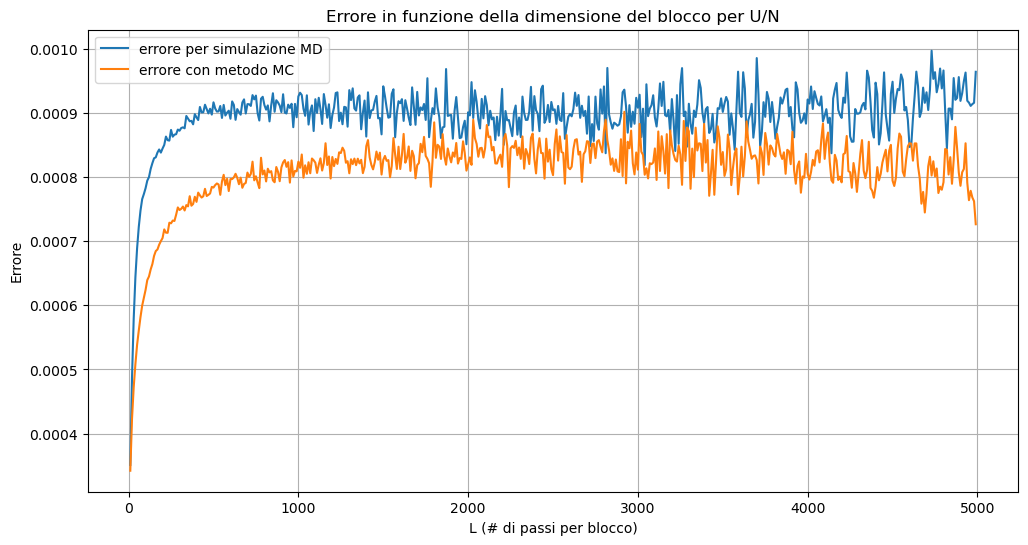

In [21]:
def calcola_errori_per_L(N, L_range, valori):
    errori = []

    for L in L_range: 
        errore = blocking_average(N, L, valori) #ogni volta aggiorno il valore di L in modo da ottenere 
        errori.append(errore)

    return np.array(errori)

valori = pot_autocorr_md["ACTUAL_PE:"].values  
valori_mc= pot_autocorr_mc["ACTUAL_PE:"].values 
N = len(valori)

L_range = np.arange(10, 5000, 10).astype(int)  # Intervallo di valori di L, con passo di 10

errori = calcola_errori_per_L(N, L_range, valori)
errori_mc= calcola_errori_per_L(N, L_range, valori_mc)

plt.figure(figsize=(12, 6))

plt.plot(L_range, errori, label= "errore per simulazione MD")
plt.plot(L_range, errori_mc, label= "errore con metodo MC")
plt.xlabel("L (# di passi per blocco)")
plt.ylabel("Errore")
plt.legend()
plt.title("Errore in funzione della dimensione del blocco per U/N")
plt.grid(True)
plt.show()

In questo plot viene mostrato l'andamento dell'errore statistico per la tecnica del data blocking in funzione del numero di steps per blocco. Per eseguire l'analisi ho considerato il numero di step totali fissato a $ n_{step} = 5 \times 10^5$. L'errore risulta essere già stabile per $\sim 10^3$ passi per blocco.

### Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

quindi due g(r) diverse: quella che sia la media cumulativa sui blocchi, e quella che si ottiene nell'ultimo blocco in modo separato in modo da poter poi fare il 7.4

### SOLUZIONE
Codice per il calcolo della GOFR, mostro questa parte del metodo `measure()` della classe `System`:

```cpp
  if (_measure_penergy or _measure_pressure or _measure_gofr) {
    for (int i=0; i<_npart-1; i++){
      for (int j=i+1; j<_npart; j++){
        distance(0) = this->pbc( _particle(i).getposition(0,true) - _particle(j).getposition(0,true), 0);
        distance(1) = this->pbc( _particle(i).getposition(1,true) - _particle(j).getposition(1,true), 1);
        distance(2) = this->pbc( _particle(i).getposition(2,true) - _particle(j).getposition(2,true), 2);
        dr = sqrt( dot(distance,distance) );// calcolo la distanza tra le particelle a due a due
        // GOFR ... TO BE FIXED IN EXERCISE 7
```

#### -  GOFR
```cpp
        if(_measure_gofr) { // sono ancora dentro al for!!!
          bin= int(dr/ _bin_size); // in base alla distanza a cui sono due particelle le inserisco in un bin (x il futuro istogramma)
          double r= bin * _bin_size;
          double delta_v = (4.0/3.0) *M_PI * ( pow( r+ _bin_size ,3)- pow( r,3) ); //crosta di volume, serve per normaliz

          if( bin < _n_bins) _measurement(_index_gofr + bin ) += (2 / (delta_v*_npart*_rho) );//aggiorno contatore delle 2 particelle
          // in questione, normalizzato secondo la formula della lezione 7
        }
        if(dr < _r_cut){
          if(_measure_penergy)  penergy_temp += 1.0/pow(dr,12) - 1.0/pow(dr,6); // POTENTIAL ENERGY
          if(_measure_pressure) virial       += 1.0/pow(dr,12) - 0.5/pow(dr,6); // PRESSURE
           
        }
      }
    }
  }

```

Qui `delta_v` rappresenta la "crosta di volume" in cui si trova la `i-esima` particella in questione. Trovare questo valore mi serve per normalizzare il conteggio delle particelle nei bins.

### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT and MD NVE simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ...  and compare your MC results for these quantities with those obtained via MD NVE simulations in similar thermodynamic conditions.</span>

#### Parametri:
- **100 Blocchi**
- **1000 Step per Blocco**

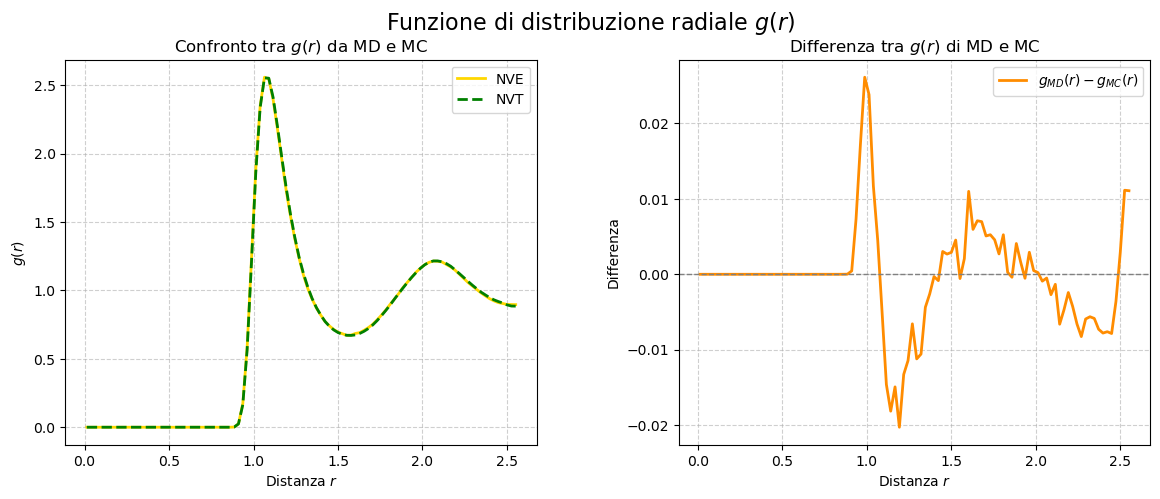

In [22]:
gofr_MD = pd.read_csv("OUTPUT/7.3/gofr_LJ_MD.dat", delim_whitespace=True)
gofr_MC = pd.read_csv("OUTPUT/7.3/gofr_LJ_MC.dat", delim_whitespace=True)

# Estrai dati
r = gofr_MD["DISTANCE:"]
g_md = gofr_MD["AVE_GOFR:"]
g_mc = gofr_MC["AVE_GOFR:"]
diff = g_md - g_mc

# Setup subplot
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'wspace': 0.3})
fig.suptitle("Funzione di distribuzione radiale $g(r)$", fontsize=16)

# confronto tra le due distr ottenute
axs[0].plot(r, g_md, label="NVE", color="gold", lw=2)
axs[0].plot(r, g_mc, label="NVT", color="green", linestyle="--", lw=2)

axs[0].set_xlabel("Distanza $r$")
axs[0].set_ylabel("$g(r)$")
axs[0].set_title("Confronto tra $g(r)$ da MD e MC")
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.6)

# Differenza tra le due distib gofr
axs[1].plot(r, diff, label="$g_{MD}(r) - g_{MC}(r)$", color="darkorange", lw=2)

axs[1].set_xlabel("Distanza $r$")
axs[1].set_ylabel("Differenza")
axs[1].set_title("Differenza tra $g(r)$ di MD e MC")
axs[1].axhline(0, color="gray", linestyle="--", linewidth=1)
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

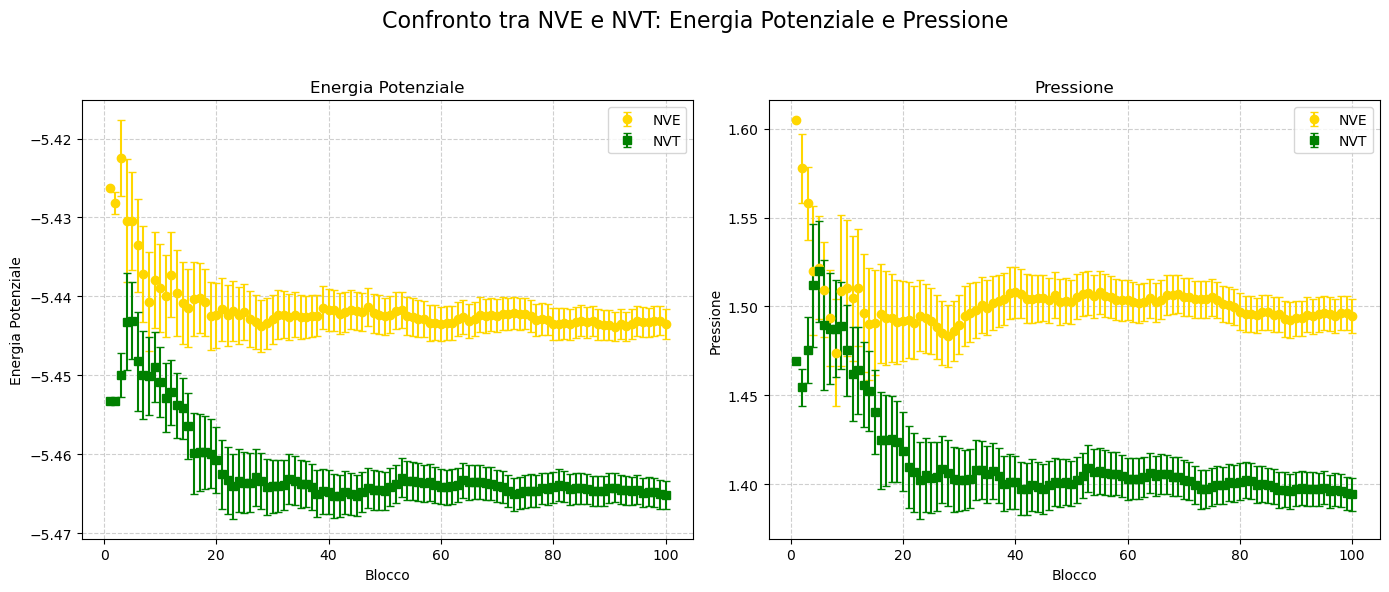

In [23]:
argon_pe_md = pd.read_csv("OUTPUT/7.3/potential_energy_LJ_MD.dat", delim_whitespace=True)
argon_pe_mc = pd.read_csv("OUTPUT/7.3/potential_energy_LJ_MC.dat", delim_whitespace=True)
argon_pr_md = pd.read_csv("OUTPUT/7.3/pressure_LJ_MD.dat", delim_whitespace=True)
argon_pr_mc = pd.read_csv("OUTPUT/7.3/pressure_LJ_MC.dat", delim_whitespace=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 riga, 2 colonne

# --- Plot 1: Potential Energy ---
axs[0].errorbar(argon_pe_md['BLOCK:'], argon_pe_md['PE_AVE:'], yerr=argon_pe_md['ERROR:'], 
                color='gold', label='NVE', fmt='o', capsize=3)
axs[0].errorbar(argon_pe_mc['BLOCK:'], argon_pe_mc['PE_AVE:'], yerr=argon_pe_mc['ERROR:'], 
                color='green', label='NVT', fmt='s', capsize=3)

axs[0].set_title('Energia Potenziale')
axs[0].set_xlabel('Blocco')
axs[0].set_ylabel('Energia Potenziale')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Pressure ---
axs[1].errorbar(argon_pr_md['BLOCK:'], argon_pr_md['P_AVE:'], yerr=argon_pr_md['ERROR:'], 
                color='gold', label='NVE', fmt='o', capsize=3)
axs[1].errorbar(argon_pr_mc['BLOCK:'], argon_pr_mc['P_AVE:'], yerr=argon_pr_mc['ERROR:'], 
                color='green', label='NVT', fmt='s', capsize=3)

axs[1].set_title('Pressione')
axs[1].set_xlabel('Blocco')
axs[1].set_ylabel('Pressione')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Confronto tra NVE e NVT: Energia Potenziale e Pressione", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Possiamo osservare che i valori di $U/N$ e $P$ sono leggermente differenti tra i due metodi di simulazione. Questo è probabilmente dovuto al fatto che la temperatura di equilibrio non è esattamente la stessa in entrambi i casi. Per quanto riguarda la funzione di distribuzione radiale $g(r)$, i risultati sono molto simili tra i due metodi di simulazione.